**Universidad de los Andes**<br>
Facultad de Ingeniería<br>
__Maestría en Inteligencia Artificial__

# Clasificador de documentos en términos de objetivos de desarrollo sostenible (ODS)

Autores: __Andrés Vega__ y __David Méndez Acuña__

## Introducción

En este notebook, presentamos nuestra solución al segundo micro-proyecto del curso de machine learning no supervisado. El objetivo es clasificar automáticamente documentos en términos de una serie de los objetivos de desarrollo sostenible fijados por Naciones Unidas. Se espera facilitar el proceso de interpretación textual procedente de diferentes fuentes implicadas en la planeación participativa para el desarrollo a nivel territorial. La Figura 1 muestra la lista de objetivos de desarrollo sostenible que se usarán para la clasificación. 


<br>
<center>
    <img src="https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/2_desarrollo_sostenible/ods.png" width="800">
</center>
<center>
Figura 1.Objetivos de desarrollo sostenible definidos por Naciones Unidas.
</center>
<br>

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from wordcloud import WordCloud

from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from IPython.display import set_matplotlib_formats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
import urllib3 # Requiere —> pip3 install urllib3

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Carga y preparación de datos

In [2]:
import pandas as pd

data_raw = pd.read_excel('./data/textos.xlsx')
data_raw

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5
...,...,...
9651,Esto implica que el tiempo de las mujeres en e...,5
9652,"Sin embargo, estas fallas del mercado implican...",3
9653,El hecho de hacerlo y cómo hacerlo dependerá e...,9
9654,"Esto se destacó en el primer estudio de caso, ...",6


In [3]:
data_raw.describe()

,ODS
count,9656.000000
mean,7.993993
std,4.692995
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,16.000000


ODS
16     1080
5      1070
4      1025
3       894
7       787
6       695
11      607
1       505
13      464
8       446
14      377
2       369
10      352
9       343
15      330
12      312
dtype: int64


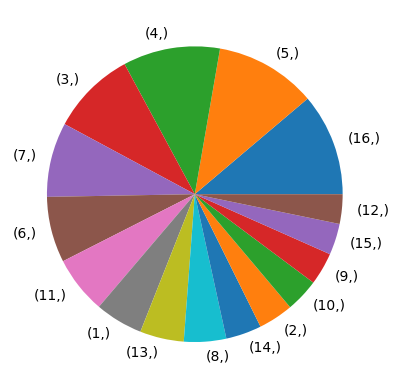

In [4]:
data_raw.iloc[:,[1]].value_counts().plot(kind='pie')
print(data_raw.iloc[:,[1]].value_counts())

Ser observa que puede haber sesgo con las clases mayoritarias 3, 4, 5 y 16

Para esto se hará un rebalanceo de clases usando undersampling en la fase de preprocesamiento de los datos.

In [5]:
data_raw.duplicated().sum()

0

In [6]:
data_raw.isna().sum()

textos    0
ODS       0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

x_train = data_raw["textos"]
y_train = data_raw["ODS"]

ods_labels = pd.DataFrame(data=['Fin de la probreza', 'Hambre cero', 'Salud y bienestar', 'Educación de calidad', 'Igualdad de género', 'Agua limpia y saneamiento',
                         'Energía asequible y no contaminante', 'Trabajo decente y desarrollo económico', 'Industria, innovación e infraestructura', 'Reducción de las desigualdades',
                         'Ciudades y comunidades sostenibles', 'Producción y consumo responsable','Acción por el clima', 'Vida submarina', 'Vida de ecosistemas terrestres', 
                         'Paz, justicia e instituciones sólidas', 'Alianzas para lograr los objetivos'], columns=["label"])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.8)

A continuación se hará un submuestreo de la data de entrenamiento utilizando `RandomUnderSampler` para evitar sesgos

1     248
2     248
3     248
4     248
5     248
6     248
7     248
8     248
9     248
10    248
11    248
12    248
13    248
14    248
15    248
16    248
Name: ODS, dtype: int64


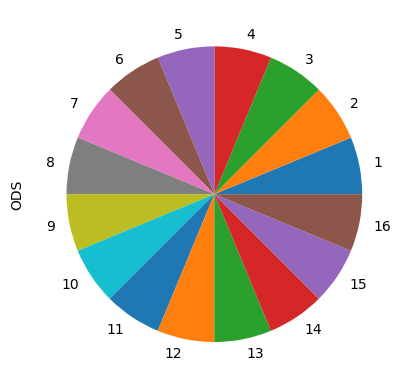

In [8]:
# Cambiando la forma de x_train a un array 2D requerido por RandomUnderSampler
X_train_reshaped = x_train.values.reshape(-1, 1)
#Balanceo de datos empleando undersampling
under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train_reshaped, y_train)

#Visuzalización de la proporción de clases en los datos de entrenamiento
y_train_under.value_counts().plot(kind='pie')
print(y_train_under.value_counts())

In [9]:
raw_mean_qty = data_raw.iloc[:,[1]].value_counts().mean()
resample_mean_qty = y_train_under.value_counts().mean()
print(f"Media de la cantidad de datos por clase previo al resampling: {raw_mean_qty}\nMedia de la cantidad de datos por clase posterior al resampling: {resample_mean_qty}\nPorcentaje aproximado de pérdida de datos en el conjunto: {round((1 - resample_mean_qty/raw_mean_qty)*100, 2)}%")

Media de la cantidad de datos por clase previo al resampling: 603.5
Media de la cantidad de datos por clase posterior al resampling: 248.0
Porcentaje aproximado de pérdida de datos en el conjunto: 58.91%


Podemos observar las 16 clases con cantidades omogéneas de datos entre ellas, sin embargo este undersampling acarrea una pérdida de poco menos del 60% de los datos.

### Nota para retroalimentación

En un principio quisimos implementar un balance de clases sin tanta pérdida utilizando SMOTE, el problema de ese enfoque fue que SMOTE requiere que la data de entrenamiento suministrada esté previamente vectorizada, nosotros hicimos la vectorización, luego la separación de datos de entrenamiento y prueba y luego pasamos el conjunto de entrenamiento por SMOTE. Esto funcionó y el conjunto de pruebas pasó a ser una matriz dispersa de forma (7724x29799). Pudimos entrenar un modelo con una alta tasa de precisión (91%) sin manipulación de hiperparámetros del modelo, pero cuando procedimos a tratar de hacer una predicción con el modelo ya entrenado, al no tener el paso de vectorización en el pipeline sino previo a la separación de los conjuntos de entrenamiento y prueba, el modelo pedía que el dato X a predecir tuviese la forma (1x29799). Vectorizar el texto que se quería predecir arrojaba una matriz dispersa de forma (1x9), por ejemplo.

Habiendo agotado las opciones, optamos por descartar este enfoque ya que a pesar de tener un modelo que generalizaba muy bien incluso sin ajustar hiper parámetros, no podíamos suministrarle datos nuevos para que los predijera.

Con todo esto nos queda la duda. ¿Existe alguna manera de utilizar SMOTE para hacer resampling del conjunto de datos sin perder tanta información en este tipo de ejercicios? y si es el caso. ¿Cómo se hace?

## Procesamiento de texto

En esta sección, se hace el procesamiento de texto necesario para transformar los documentos en bolsas de palabras. 

In [10]:
def preprocess(data):
  """
  Realiza el preprocesamiento básico de datos de texto en español.

  Parámetros:
  - data : pandas.Series
      Una serie de pandas que contiene datos de texto para preprocesar.

  Retorna:
  - tuple
      Una tupla que contiene dos elementos:
      1. Una pandas.Series que contiene los datos preprocesados con tokens tokenizados, sin stopwords y aplicando stemming.
      2. Una pandas.Series que contiene los tokens tokenizados sin stopwords.
  """
  tokenizer = RegexpTokenizer(r'\w+')
  tokenized_no_punct = data.apply(lambda x: tokenizer.tokenize(x))

  nltk_stopwords = stopwords.words("spanish")
  no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])  

  stemmer = PorterStemmer()
  stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])

  processed = stemmed.apply(lambda x: ' '.join(x))
   
  return (processed, no_stopwords)

In [11]:
processed, no_stopwords = preprocess(x_train)

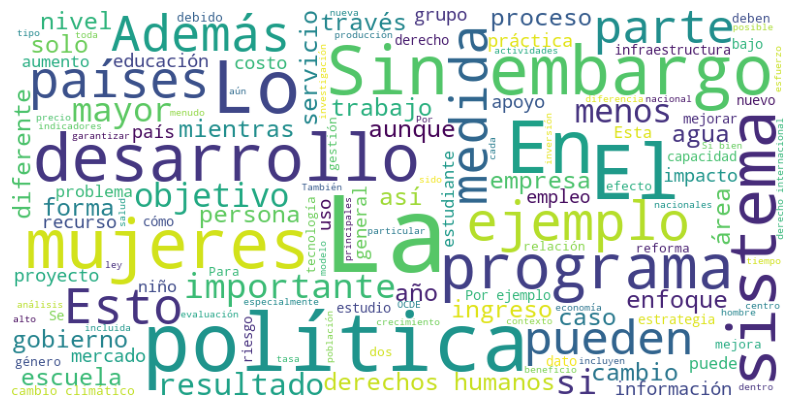

In [12]:
wc_text = ' '.join(word for text in no_stopwords for word in text)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110
).generate(wc_text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Visualización de los datos en 2D usando t-SNE

In [13]:
tsvd = TruncatedSVD(n_components=100)

In [14]:
set_matplotlib_formats('retina')

def visualize(data=None, dimred=None) :
    '''
    Este método permite visualizar los datos de entrada en un plano cartesiano de dos dimensiones
    a través del algoritmo de t-SNE. 
    '''
    data_dimred = dimred.fit_transform(data)

    tsne = TSNE(n_components=2, random_state=0, verbose=0, n_jobs=-1, learning_rate=10, perplexity=30, n_iter=3000, init='random', metric='cosine')
    data_tsne = tsne.fit_transform(data_dimred)

    N = 7724
    np.random.seed(42)
    random = np.random.permutation(data_raw.shape[0])

    consolidated_data = data_raw.loc[random[:N],:].copy()
    consolidated_data['ODS_labels'] = [ ods_labels.values[consolidated_data.iloc[i]['ODS']][0] for i in range(len(consolidated_data))]
    consolidated_data['tsne-x'] = data_tsne[:,0]
    consolidated_data['tsne-y'] = data_tsne[:,1]

    fig, ax = plt.subplots(figsize=(15, 7))
    scatter = ax.scatter(consolidated_data['tsne-x'], consolidated_data['tsne-y'],  c=consolidated_data['ODS'], cmap="tab20b")
    legend = ax.legend(*scatter.legend_elements(num=16), loc="upper left", title="ODS")
    ax.add_artist(legend)

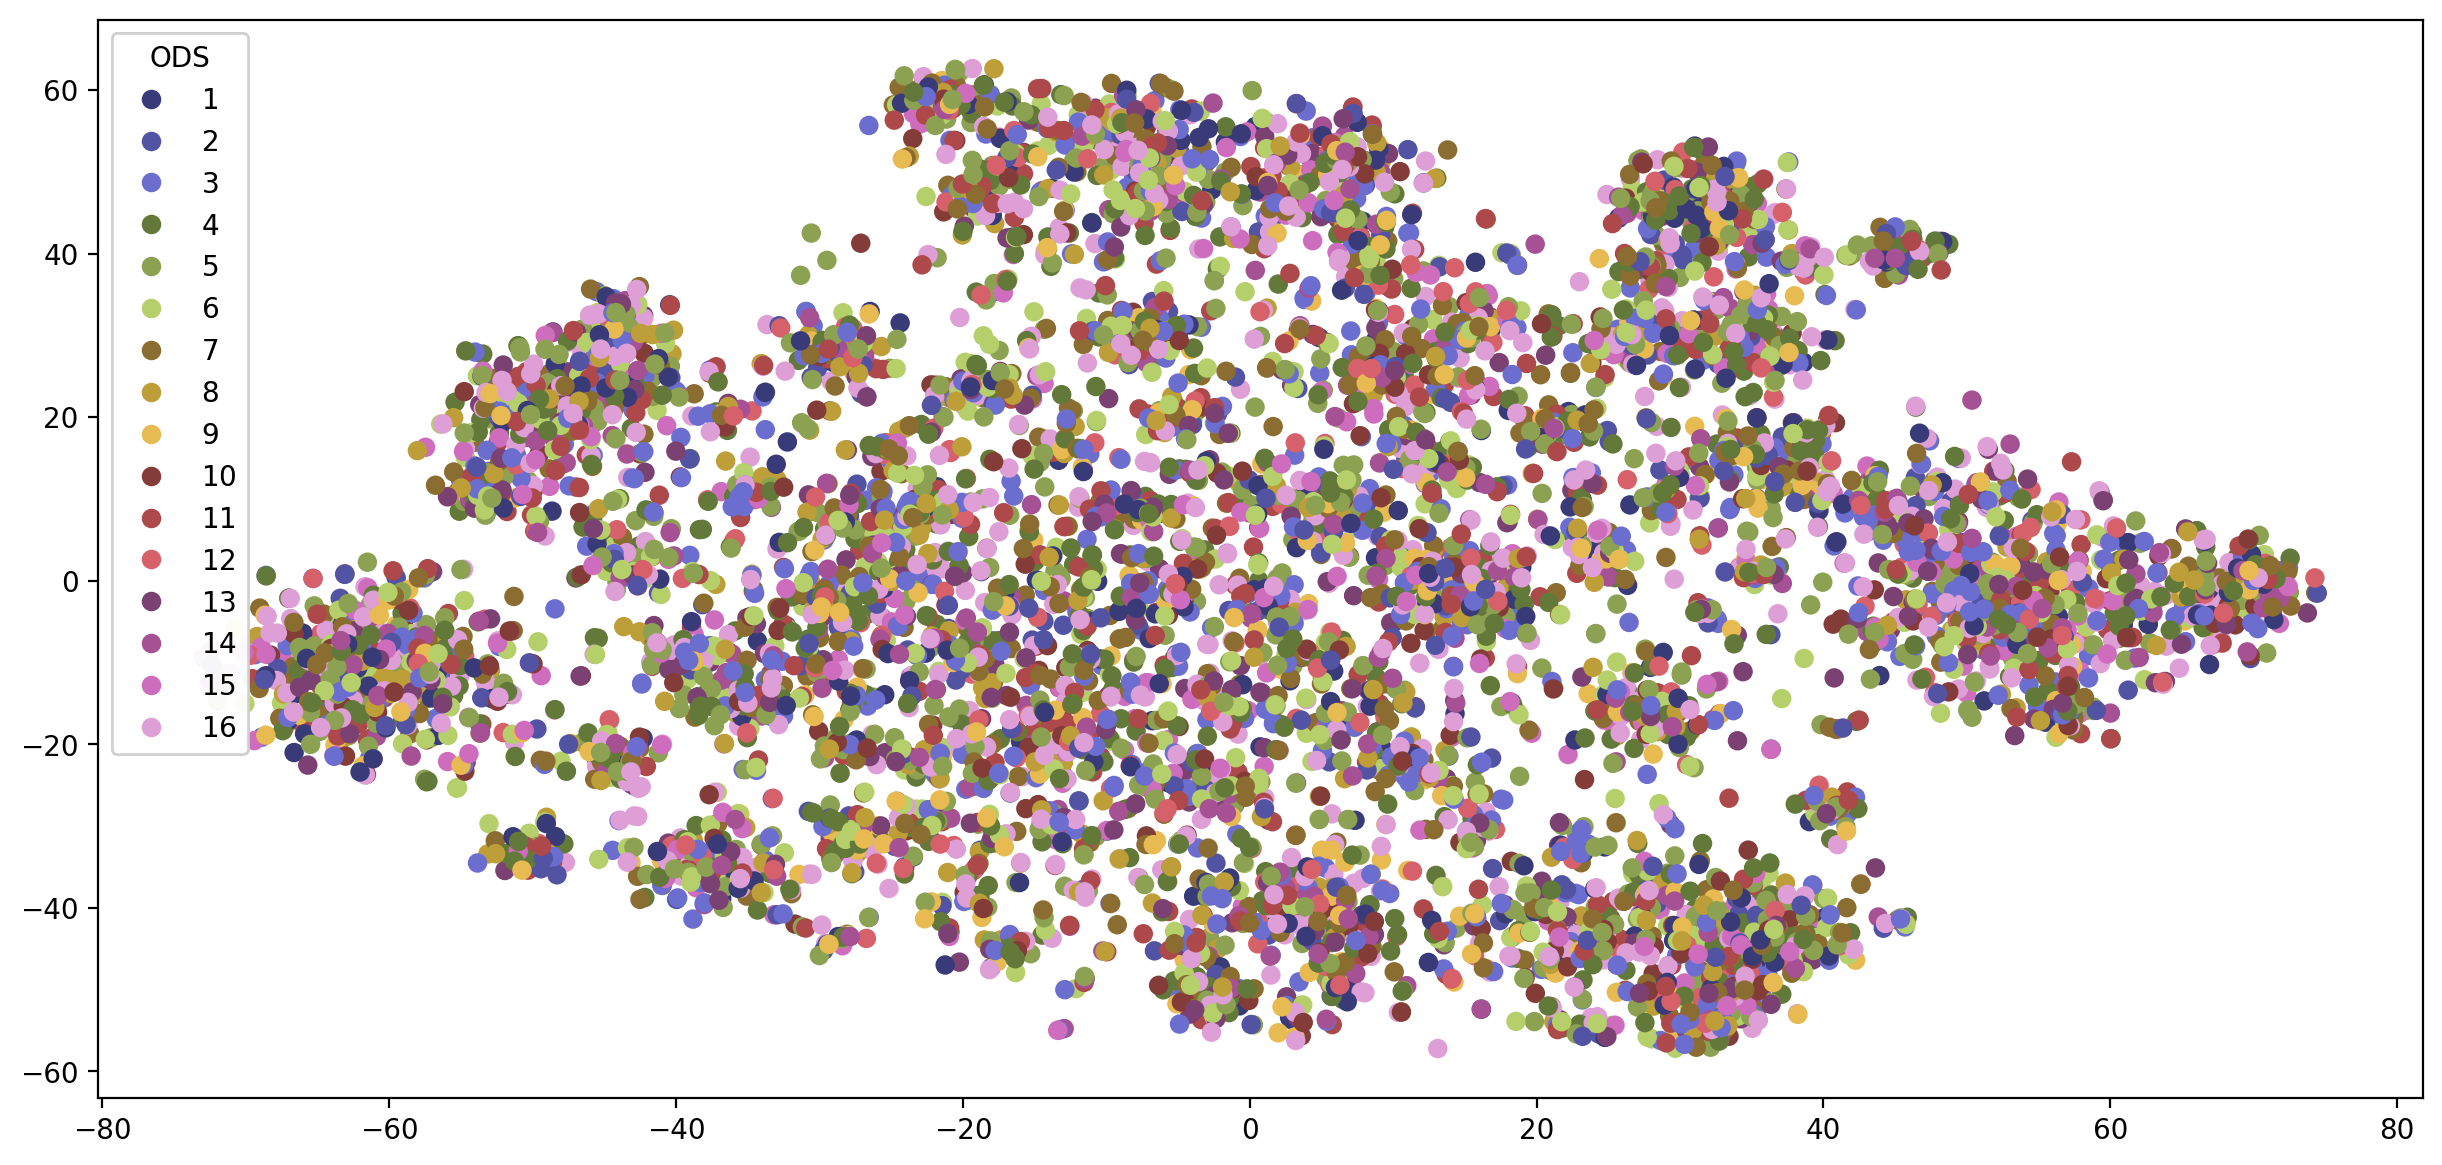

In [15]:
vectorizer_countVectorizer = CountVectorizer()
data_countVectorizer = vectorizer_countVectorizer.fit_transform(processed)
visualize(data=data_countVectorizer, dimred=tsvd)


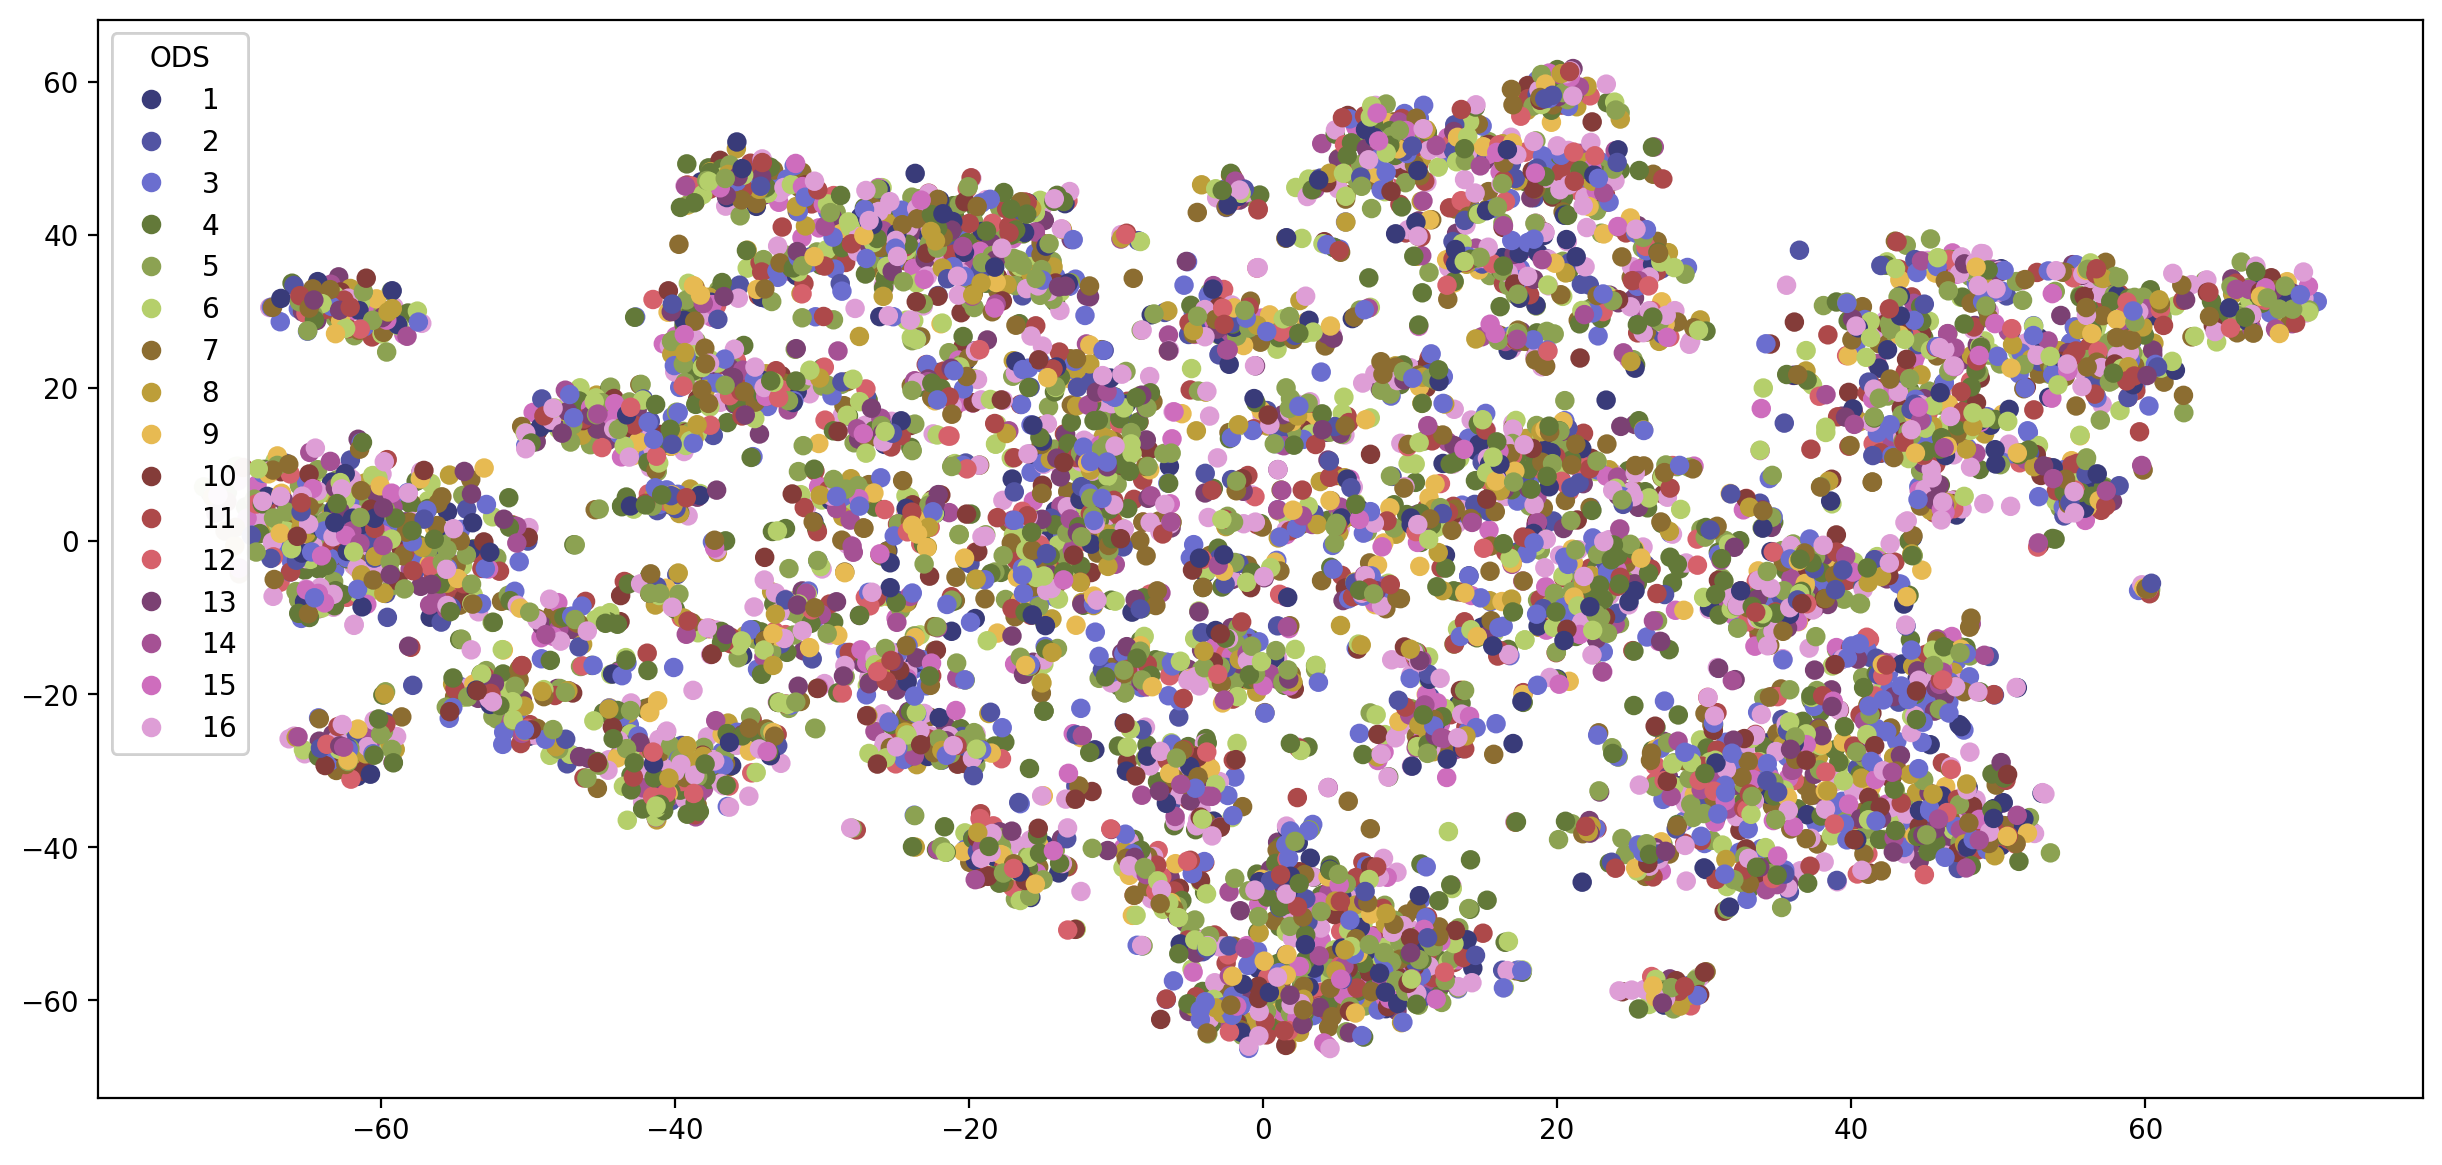

In [16]:
vectorizer_tfidVectorizer = TfidfVectorizer()
data_tfidVectorizer = vectorizer_tfidVectorizer.fit_transform(processed)
visualize(data=data_tfidVectorizer, dimred=tsvd)

## Selección del modelo de clasificación y entrenamiento

Existen varios modelos que pueden ayudarnos con este problema de clasificación. Para seleccionar un modelo apropiado, usamos una metodología basada en dos pasos. Por un lado, comparamos el desempeño de varios modelos con los valores de hiper-parámetros por defecto y sobre dos tipos de representación en bolsa de palabras distintas. 

Los modelos que incluimos en la comparación son:

- RandomForest
- Support Vector Machine con kernel lineal
- Support Vector Machine con kernel Gaussiano
- Regresión logística
- Multi-layer Perceptron Classifier.

Para la representación de bolsa de palabras, incluimos dos métodos en la comparación: 

- CountVectorizer
- TfidfVectorizer

A partir de esta comparación inicial, seleccionamos el mejor modelo con la mejor representación de bolsa de palabras y procedemos a encontrar los mejor valores para los hiper-parámetros.

### Selección del modelo

In [17]:


def train_and_evaluate_models(models):
    '''
    Recorre los modelos que entran por parámetro, ejecuta la función de entrenamiento
    y almacena los resultados de precisión en un dataframe que se retorna al final de le ejecución.
    '''
    model_evaluation = []
    print('Inicio del entrenamiento y evaluación de los modelos')
    for model in models:
        print(f' — Entrenamiento y evaluación en curso para -> {model[0]}')
        pipeline, accuracy = train_and_evaluate(model[1], model[2], model[3])
        model_evaluation.append([model[0], accuracy])

    model_evaluation_frame = pd.DataFrame(data=model_evaluation, columns=["Name", "Accuracy"])
    display(model_evaluation_frame)
    print('Fin de entrenamiento y evaluación. Los resultados se presentan a continuación:')

    fig, ax = plt.subplots()
    plt.barh(
        y=model_evaluation_frame['Name'],
        width=model_evaluation_frame['Accuracy'], 
        color='purple'
    )
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, color='#EEEEEE')
    ax.yaxis.grid(False)
    ax.set_ylabel('Modelo', labelpad=15, color='#333333', weight='bold')
    ax.set_title('Precisión en los datos de prueba', pad=15, color='#333333', weight='bold')
    fig.show()



def train_and_evaluate(model=None, dimred=None, vectorizer=None, verbose=False) : 
    '''
    Este método se encarga de crear y ejecutar un pipeline de entrenamiento que a partir de la bolsa
    de palabras en el parámetro 'vectorizer' aplica el algoritmo de reducción de la dimensionalidad
    y entrena el modelo dado. Durante la ejecución de este método, se imprime el reporte de clasificación
    correspondiente. 
    '''
    steps = [
        ("vectorizer", vectorizer),
        ("dimred", dimred),
        ("model", model)
    ]
    pipeline = Pipeline(steps)
    X_train_under_series = pd.Series(X_train_under.flatten())
    pipeline.fit(X_train_under_series, y_train_under)    
    y_pred = pipeline.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    return pipeline, accuracy

Inicio del entrenamiento y evaluación de los modelos
 — Entrenamiento y evaluación en curso para -> Vectorizer: CountVectorizer — Model: RandomForest
 — Entrenamiento y evaluación en curso para -> Vectorizer: CountVectorizer — Model: SVC (Gaussian kernel)
 — Entrenamiento y evaluación en curso para -> Vectorizer: CountVectorizer — Model: SVC (Linear kernel)
 — Entrenamiento y evaluación en curso para -> Vectorizer: CountVectorizer — Model: LogisticRegression
 — Entrenamiento y evaluación en curso para -> Vectorizer: CountVectorizer — Model: MLPClassifier
 — Entrenamiento y evaluación en curso para -> Vectorizer: TfidfVectorizer — Model: RandomForest
 — Entrenamiento y evaluación en curso para -> Vectorizer: TfidfVectorizer — Model: SVC (Gaussian kernel)
 — Entrenamiento y evaluación en curso para -> Vectorizer: TfidfVectorizer — Model: SVC (Linear kernel)
 — Entrenamiento y evaluación en curso para -> Vectorizer: TfidfVectorizer — Model: LogisticRegression
 — Entrenamiento y evaluación

,Name,Accuracy
0,Vectorizer: CountVectorizer — Model: RandomForest,0.668737
1,Vectorizer: CountVectorizer — Model: SVC (Gaus...,0.696687
2,Vectorizer: CountVectorizer — Model: SVC (Line...,0.747412
3,Vectorizer: CountVectorizer — Model: LogisticR...,0.781056
4,Vectorizer: CountVectorizer — Model: MLPClassi...,0.744824
5,Vectorizer: TfidfVectorizer — Model: RandomForest,0.791408
6,Vectorizer: TfidfVectorizer — Model: SVC (Gaus...,0.850932
7,Vectorizer: TfidfVectorizer — Model: SVC (Line...,0.834886
8,Vectorizer: TfidfVectorizer — Model: LogisticR...,0.832816
9,Vectorizer: TfidfVectorizer — Model: MLPClassi...,0.842650


Fin de entrenamiento y evaluación. Los resultados se presentan a continuación:


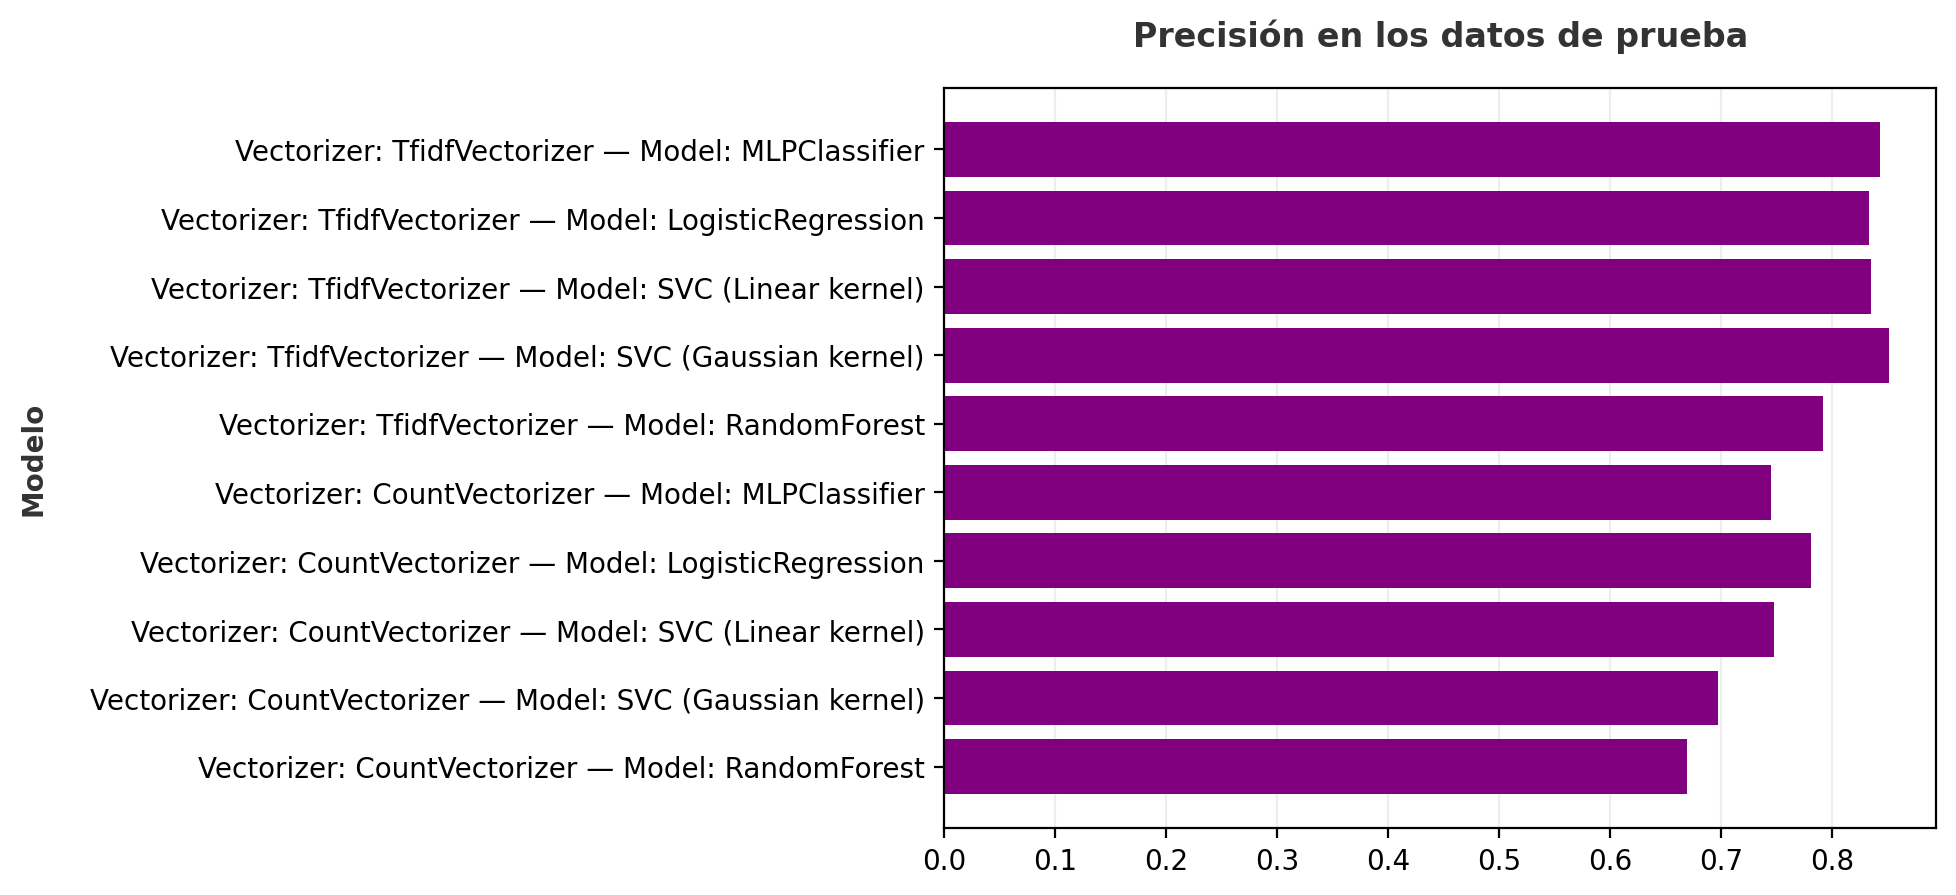

In [18]:
models = [
    ('Vectorizer: CountVectorizer — Model: RandomForest', RandomForestClassifier(), tsvd, vectorizer_countVectorizer),
    ('Vectorizer: CountVectorizer — Model: SVC (Gaussian kernel)', SVC(kernel='rbf'), tsvd, vectorizer_countVectorizer),
    ('Vectorizer: CountVectorizer — Model: SVC (Linear kernel)', SVC(kernel='linear'), tsvd, vectorizer_countVectorizer),
    ('Vectorizer: CountVectorizer — Model: LogisticRegression', LogisticRegression(), tsvd, vectorizer_countVectorizer),
    ('Vectorizer: CountVectorizer — Model: MLPClassifier', MLPClassifier(), tsvd, vectorizer_countVectorizer),
    ('Vectorizer: TfidfVectorizer — Model: RandomForest', RandomForestClassifier(), tsvd, vectorizer_tfidVectorizer),
    ('Vectorizer: TfidfVectorizer — Model: SVC (Gaussian kernel)', SVC(kernel='rbf'), tsvd, vectorizer_tfidVectorizer),
    ('Vectorizer: TfidfVectorizer — Model: SVC (Linear kernel)', SVC(kernel='linear'), tsvd, vectorizer_tfidVectorizer),
    ('Vectorizer: TfidfVectorizer — Model: LogisticRegression', LogisticRegression(), tsvd, vectorizer_tfidVectorizer),
    ('Vectorizer: TfidfVectorizer — Model: MLPClassifier', MLPClassifier(), tsvd, vectorizer_tfidVectorizer)
]

train_and_evaluate_models(models)

Seleccionamos el modelo con mejor desempeño: SVC con kernel gaussiano y grado 5

In [19]:
pipeline, accuracy = train_and_evaluate(model = SVC(kernel='rbf', degree=5), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8504140786749482


## Validación: Predicción en nuevos textos

Finalmente, utilizaomos el mejor modelo (en este caso, una red neuronal que sigue una arquitectura conforme a "multi-layer perceptron") para clasificar documentos nuevos. 

In [20]:
http = urllib3.PoolManager()

def download_content(file_name = None) -> str :
    '''
    Descarga el archivo de acuerdo con el nombre que entra en el parámetro. 
    La descarga se hace desde el repositorio asociado a este proyecto. 
    '''
    base_path = "https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/2_desarrollo_sostenible/data/publicaciones/"
    url = base_path + file_name
    response = http.request('GET', url)
    return response.data


def predecir(file_name = None, texto = None, pipeline=pipeline) :
    '''
    Usa el pipeline de predicción entrenado anteriormente para clasificar el documento que entra por parámetro. 
    El documento puede recibirse en forma de texto (usando el parametro 'texto') o a partir de un nombre de archivo
    que será descargado desde el repositorio de GitHub asociado al presente proyecto. 
    '''
    if texto == None :
        texto = download_content(file_name) 

    serie_prueba = pd.Series(data=[texto])
    prediccion_prueba = pipeline.predict(serie_prueba)
    resultado = ods_labels.iloc[prediccion_prueba[0]-1,0]
    return resultado, prediccion_prueba[0]

#### Ejemplo sencillo
Empezamos con una prueba sencilla de un texto escrito por los autores de este notebook. 

In [21]:
texto = 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'
predecir(texto = texto, pipeline = pipeline)

('Agua limpia y saneamiento', 6)

#### Publicaciones en el sitio de Naciones Unidas en Colombia

Ahora, procedemos a clasificar documentos completos tomados del sitio web de las Naciones Uniades en Colombia y los clasificamos con respecto al objetivo de desarollo sostenible con el que se relacionan. 

Publicación sobre la lucha contra el VIH/SIDA y la relación entre la disriminación contra personas LBGT y su vulnerabilidad frente a las enfermedades de transmisión sexual. 

**Fuente:** https://colombia.un.org/es/262073-día-de-la-cero-discriminación-para-proteger-la-salud-de-todas-las-personas-hay-que-proteger 

In [22]:
predecir(file_name='publicacion_1.txt', pipeline = pipeline)

('Igualdad de género', 5)

Publicación sobre la visita de campo de la reina de los Paises Bajos al Valle de Aburrá (cerca de Medellín). Se trata de una visita de observación que muestra como dos empresas colombianas están trabajando en usar tecnología para facilitar el desarollo agrícola de la región. 

**Fuente:** https://colombia.un.org/es/261802-tecnología-y-finanzas-para-fomentar-un-futuro-más-verde 

In [23]:
predecir(file_name='publicacion_2.txt', pipeline = pipeline)

('Industria, innovación e infraestructura', 9)

Publicación sobre la tercera visita del Consejo de Seguridad de la ONU a Colombia como parte de su seguimiento a los acuerdos de paz. 

**Fuente:** https://colombia.un.org/es/261491-colombia-la-paz-una-causa-social-real-que-entraña-un-esfuerzo-de-parte-de-toda-la-sociedad

In [24]:
predecir(file_name='publicacion_3.txt', pipeline = pipeline)

('Paz, justicia e instituciones sólidas', 16)

## Clasificación de las publicaciones de Naciones Unidas Colombia durante los años 2023 y 2024

Otra manera interesante de explotar el modelo construido en este documento, es analizar los documentos de una cierta fuente e identificar los objetivos de desarrollo sostenible más representados. En este caso, decidimos recopilar los documentos en la categoría de "Historias" del sitio webn de las Naciones Unidas en Colombia durante los años 2023 y 2024, para analizarlas con el clasificador. Es importante mencionar que seleccionamos la sección de "Historias" porque es precisamente esta sección la que se encarga de compilar los esfuerzos de Naciones Unidas para que el país logre sus objetivos desarrollo sostenible. 

**Fuente:** https://colombia.un.org/es/stories

__Nota:__ Las publicaciones han sido organizadas en archivos de texto y publicadas en un repositorio en GitHub. El código a continuación, se encarga de descargar los archivos correspondientes, ejecutar la inferencia sobre el modelo de clasificación y consolidar los resultados en un diagrama de barras.

In [25]:
publications_count = np.zeros(len(ods_labels))

for i in range(1, 38):
    label, index = predecir(file_name="publicacion_" + str(i) + ".txt", pipeline = pipeline)
    publications_count[index - 1] = publications_count[index - 1] + 1

ods_labels["publications"] = publications_count
ods_labels

,label,publications
0,Fin de la probreza,1.0
1,Hambre cero,1.0
2,Salud y bienestar,3.0
3,Educación de calidad,0.0
4,Igualdad de género,16.0
5,Agua limpia y saneamiento,0.0
6,Energía asequible y no contaminante,0.0
7,Trabajo decente y desarrollo económico,0.0
8,"Industria, innovación e infraestructura",6.0
9,Reducción de las desigualdades,0.0


Text(0.5, 1.0, 'Cantidad de publicaciones')

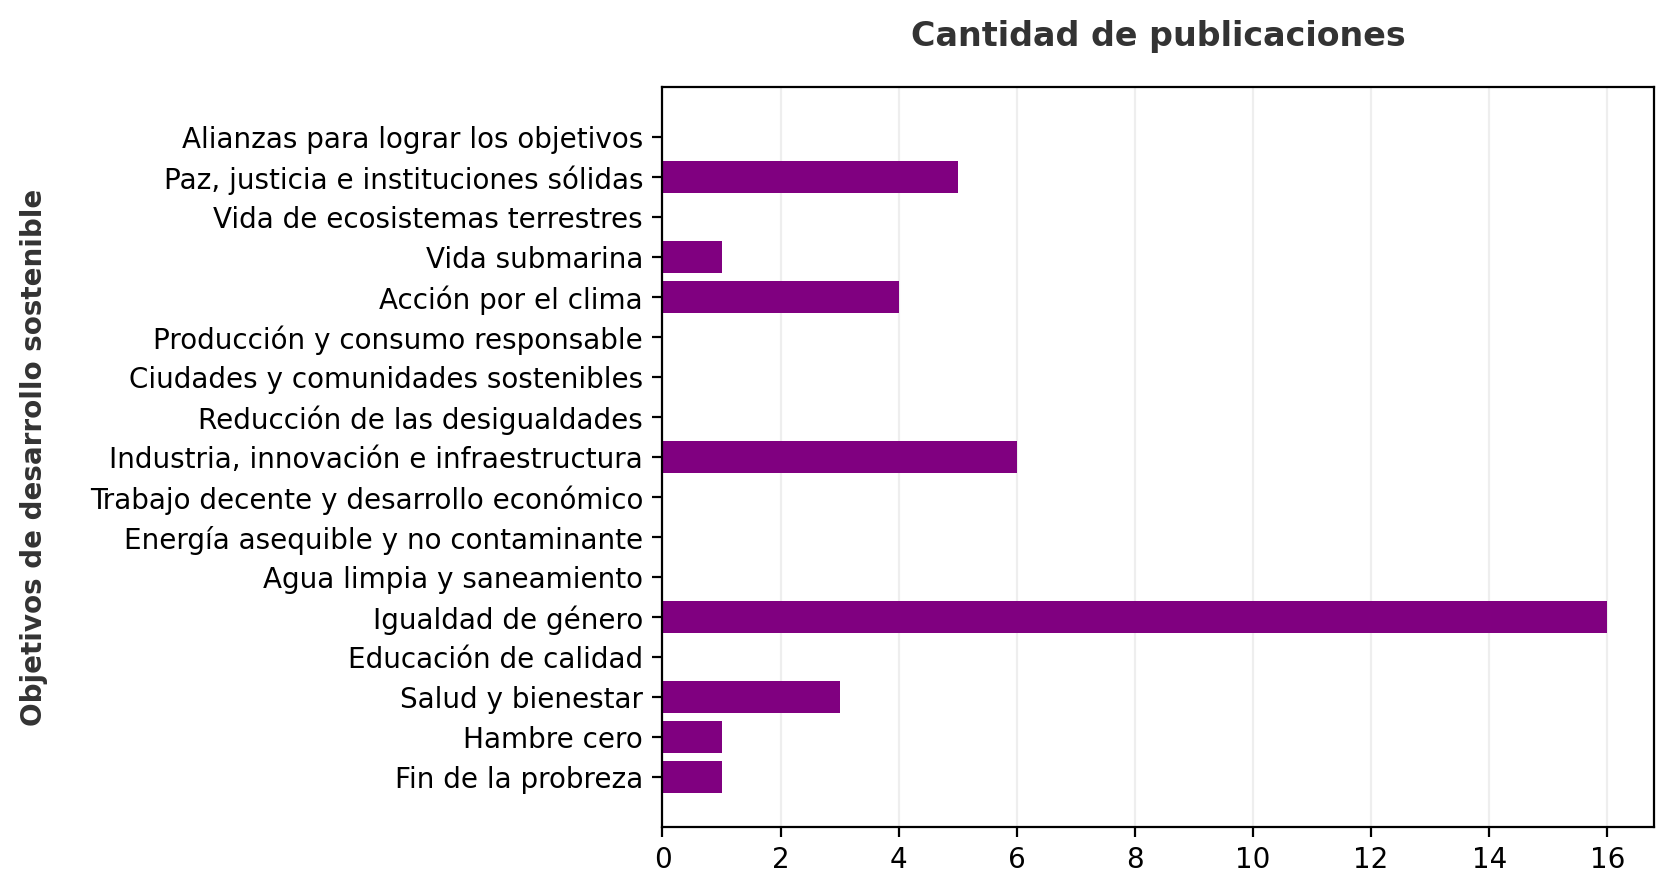

In [26]:
fig, ax = plt.subplots()
plt.barh(
    y=ods_labels['label'],
    width=ods_labels['publications'], 
    color='purple'
)
ax.set_axisbelow(True)
ax.xaxis.grid(True, color='#EEEEEE')
ax.yaxis.grid(False)
ax.set_ylabel('Objetivos de desarrollo sostenible', labelpad=15, color='#333333', weight='bold')
ax.set_title('Cantidad de publicaciones', pad=15, color='#333333', weight='bold')